# **Facial Emotion Detection**

## **Problem Definition**

**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What are we trying to solve using data science?



## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## **Importing the Libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import warnings
warnings.filterwarnings("ignore")

### **Let us load and unzip the data**

In [ ]:
# path of zip file
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# unzipping the file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

## **Visualizing our Classes**


### **Happy**

**Observations and Insights:**
- Most of the pictures that they have are clear smiles, there aren't any hidden smiles
- The ages vary, there is no set age
- The angles can change depending on the picture
- Some images also aren't of people smiling

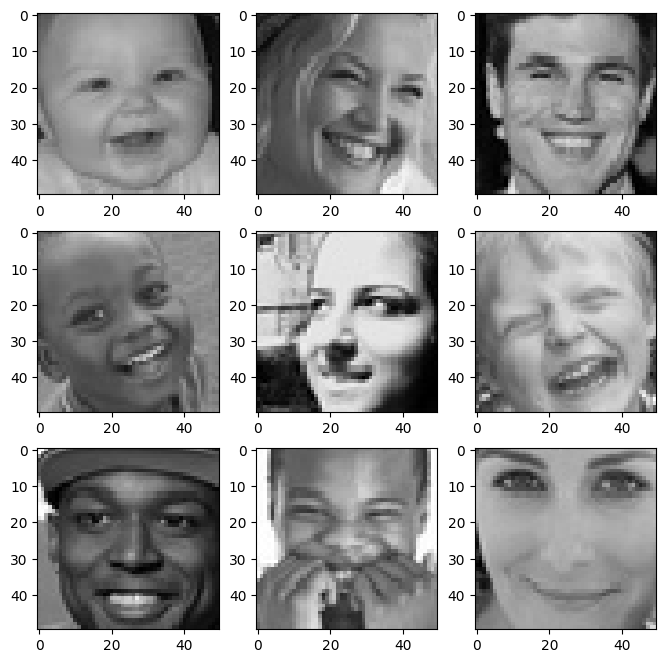

In [ ]:
plt.figure(figsize= (8,8))

for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img("Facial_emotion_images/train/happy/" + os.listdir("Facial_emotion_images/" + "train/" + "happy")[i], target_size = (50, 50))
    plt.imshow(img)

plt.show()

### **Sad**

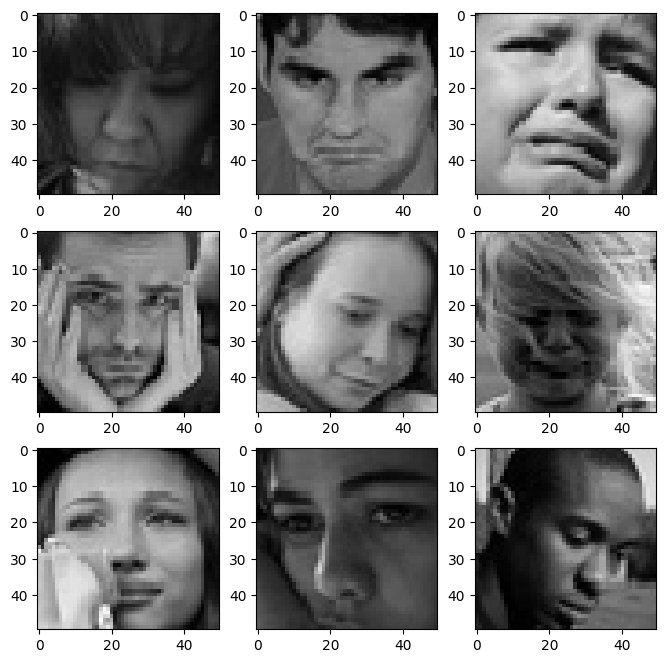

In [ ]:
plt.figure(figsize= (8,8))

for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img("Facial_emotion_images/train/sad/" + os.listdir("Facial_emotion_images/" + "train/" + "sad")[i], target_size = (50, 50))
    plt.imshow(img)

plt.show()

**Observations and Insights:**
- There's a large range of images that are considered "sad" (slight frown, crying, straight face)
- Angles and ages both vary again

### **Neutral**

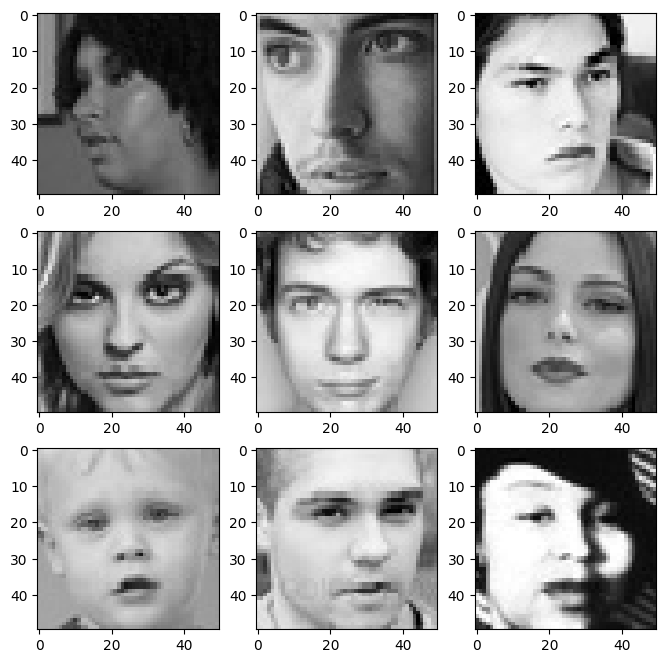

In [ ]:
plt.figure(figsize= (8,8))

for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img("Facial_emotion_images/train/neutral/" + os.listdir("Facial_emotion_images/" + "train/" + "neutral")[i], target_size = (50, 50))
    plt.imshow(img)

plt.show()

**Observations and Insights:**
- Not much variety in the faces, mostly everly has a straight face
- Angles are the same but ages vary again

### **Surprised**

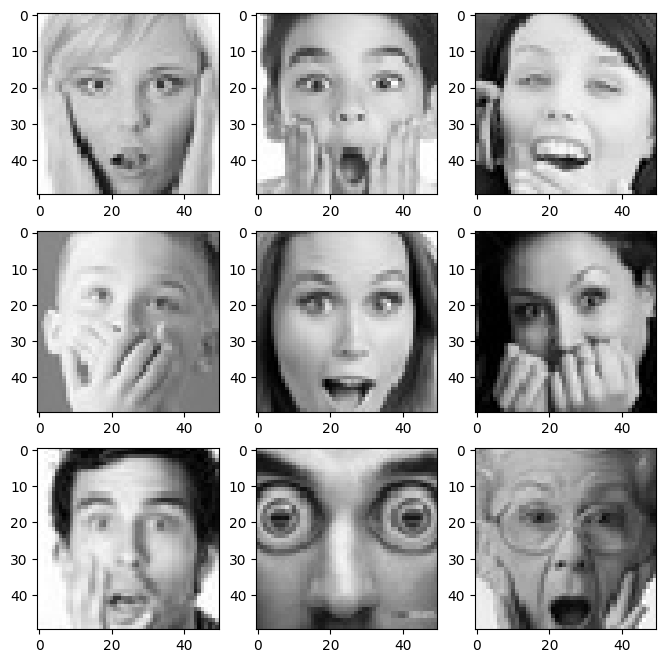

In [ ]:
plt.figure(figsize= (8,8))

for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img("Facial_emotion_images/" + "train/" + "surprise" + "/" + os.listdir("Facial_emotion_images/" + "train/" + "surprise")[i], target_size = (50, 50))
    plt.imshow(img)

plt.show()

**Observations and Insights:**
- It's mostly shocked faces, with the person's mouth open
- The features are very clear as to what the surprised face is supposed to be

## **Checking Distribution of Classes**

Number of images in the class 'happy':    3976
Number of images in the class 'sad':    3982
Number of images in the class 'neutral':    3978
Number of images in the class 'surprise':    3173


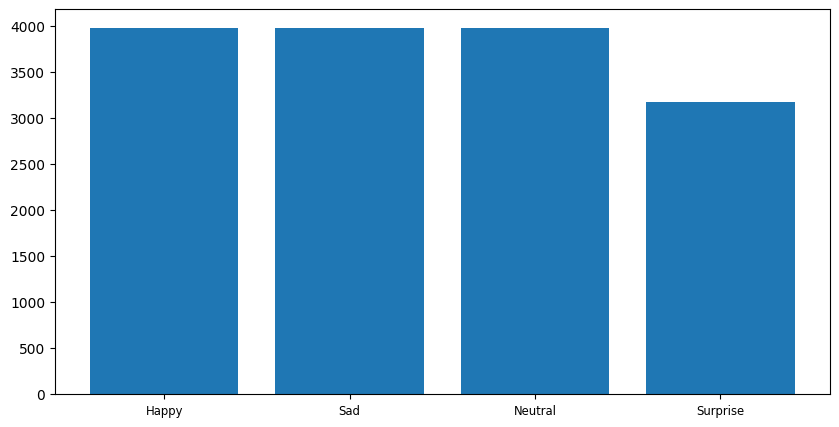

In [ ]:
classes_happy = len(os.listdir("Facial_emotion_images/train/happy"))
print("Number of images in the class 'happy':   ", classes_happy)

classes_sad = len(os.listdir("Facial_emotion_images/train/sad"))
print("Number of images in the class 'sad':   ", classes_sad)

classes_neutral = len(os.listdir("Facial_emotion_images/train/neutral"))
print("Number of images in the class 'neutral':   ", classes_neutral)

classes_surprise = len(os.listdir("Facial_emotion_images/train/surprise"))
print("Number of images in the class 'surprise':   ", classes_surprise)

plt.figure(figsize = (10, 5))

data = {'Happy': classes_happy, 'Sad': classes_sad, 'Neutral': classes_neutral, 'Surprise' : classes_surprise}

df = pd.Series(data)
plt.bar(range(len(df)), df.values, align = 'center')
plt.xticks(range(len(df)), df.index.values, size = 'small')

plt.show()

**Observations and Insights:**
- The happy, sad, neutral classes all have pretty much the same number of images, but the surprise class has about 800 images less
- It shouldn't affect the models too much though since it should be easy to determine the shocked faces

## **Creating our Data Loaders**

In [ ]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True, brightness_range = (0.,2.), rescale = 1./255, shear_range = 0.3)

train_set = datagen_train.flow_from_directory("Facial_emotion_images/train", target_size = (img_size, img_size), color_mode = 'rgb', batch_size = batch_size, class_mode = 'categorical', shuffle = True)


datagen_validation = ImageDataGenerator(horizontal_flip = True, brightness_range=(0.,2.), rescale=1./255, shear_range=0.3)

validation_set = datagen_validation.flow_from_directory("Facial_emotion_images/validation", target_size = (img_size, img_size), color_mode = 'rgb', batch_size = batch_size, class_mode = 'categorical', shuffle = True)


datagen_test = ImageDataGenerator(horizontal_flip = True, brightness_range = (0.,2.), rescale = 1./255, shear_range = 0.3)

test_set = datagen_test.flow_from_directory("Facial_emotion_images/test", target_size = (img_size, img_size), color_mode = 'rgb', batch_size = batch_size, class_mode = 'categorical', shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **Model Building**

### **Creating the Base Neural Network**

In [ ]:
cnn_model_1 = Sequential()

# convolutional block #1
cnn_model_1.add(Conv2D(64, kernel_size=(2), padding='same', activation='relu', input_shape=(48,48,3)))
cnn_model_1.add(MaxPooling2D(pool_size=(2)))
cnn_model_1.add(Dropout(rate=0.2))

# convolutional block #2
cnn_model_1.add(Conv2D(32, kernel_size=(2), padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(2)))
cnn_model_1.add(Dropout(rate=0.2))

# convolutional block #3
cnn_model_1.add(Conv2D(32, kernel_size=(2), padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(2)))
cnn_model_1.add(Dropout(rate=0.2))

cnn_model_1.add(Flatten())

cnn_model_1.add(Dense(512, activation='relu'))

cnn_model_1.add(Dropout(rate=0.4))

cnn_model_1.add(Dense(4, activation='softmax'))

cnn_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 605,572 (2.31 MB)

 Trainable params: 605,572 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy

# saving a checkpoint of the weight from the best epoch
checkpoint = ModelCheckpoint("./cnn_model1.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# early stopping for if the validation loss doesn't get better
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

# reduced learning rate for if the validation loss doesn't get better
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# compiling the model with all the parameters set
cnn_model_1.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = 0.001), metrics = ["accuracy"])

# fitting the model
cnn_model_1_history = cnn_model_1.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.2740 - loss: 1.3846 - val_accuracy: 0.3769 - val_loss: 1.2731
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - accuracy: 0.4204 - loss: 1.2602 - val_accuracy: 0.5206 - val_loss: 1.1303
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.5056 - loss: 1.1314 - val_accuracy: 0.5765 - val_loss: 1.0069
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - accuracy: 0.5341 - loss: 1.0749 - val_accuracy: 0.5853 - val_loss: 0.9992
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.5487 - loss: 1.0365 - val_accuracy: 0.5913 - val_loss: 0.9608
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.5650 - loss: 1.0115 - val_accuracy: 0.6082 - val_loss: 0.9529
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.5795 - loss: 0.9927 - val_accuracy: 0.6104 - val_loss: 0.9414
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - accuracy: 0.5787 - loss: 0.9774 - 

### **Evaluating the Model on the Test Set**

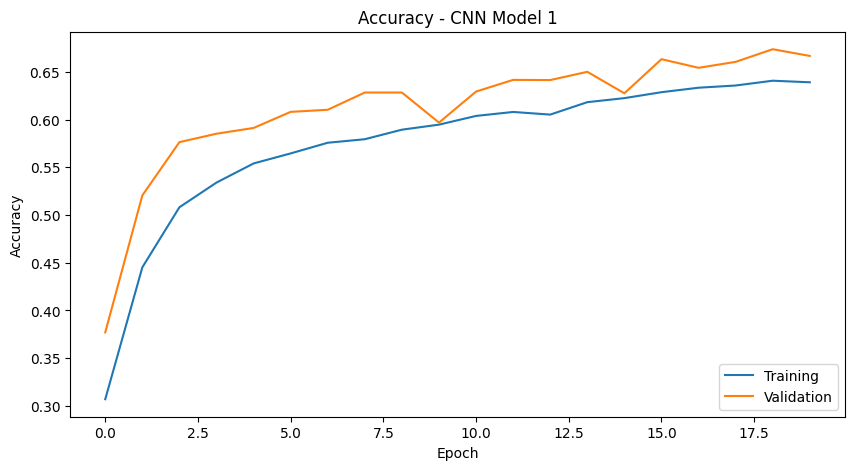

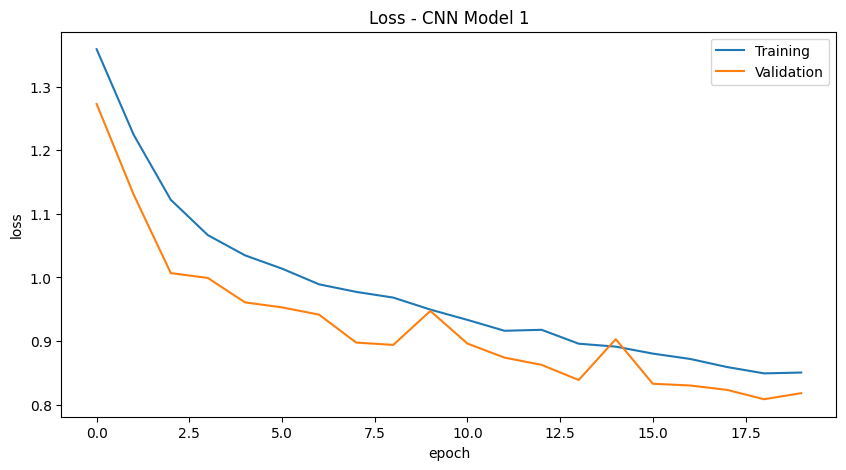

In [ ]:
# plotting the accuracies and losses

plt.figure(figsize = (10, 5))
plt.plot(cnn_model_1_history.history['accuracy'])
plt.plot(cnn_model_1_history.history['val_accuracy'])
plt.title('Accuracy - CNN Model 1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(cnn_model_1_history.history['loss'])
plt.plot(cnn_model_1_history.history['val_loss'])
plt.title('Loss - CNN Model 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# getting the accuracy of the test set of the model
cnn_model_1_eval = cnn_model_1.evaluate(test_set)

# printing the loss and accuracy values
print('CNN model 1 test set loss:', cnn_model_1_eval[0])
print('CNN model 1 test set accuracy:', cnn_model_1_eval[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6208 - loss: 0.8500
CNN model 1 test set loss: 0.8279955983161926
CNN model 1 test set accuracy: 0.6328125


**Observations and Insights:**
- The accuracy sits at around 63% and the loss is around 0.83 based on the test set
- The accuracy stalled at around 60-65%, showing the limitations of the model
- Not useful, there are better models for this

### **Creating the second Convolutional Neural Network**

In [ ]:
cnn_model_2 = Sequential()

# convolutional block #1
cnn_model_2.add(Conv2D(256, kernel_size=(2), padding='same', activation='relu', input_shape=(48, 48, 3)))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(LeakyReLU(alpha=0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2)))

# convolutional block #2
cnn_model_2.add(Conv2D(128, kernel_size=(2), padding='same', activation='relu'))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(LeakyReLU(alpha=0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2)))

# convolutional block #3
cnn_model_2.add(Conv2D(64, kernel_size=(2), padding='same', activation='relu'))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(LeakyReLU(alpha=0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2)))

# convolutional block #4
cnn_model_2.add(Conv2D(32, kernel_size=(2), padding='same', activation='relu'))
cnn_model_2.add(BatchNormalization())
cnn_model_2.add(LeakyReLU(alpha=0.1))
cnn_model_2.add(MaxPooling2D(pool_size=(2)))

cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(512, activation='relu'))
cnn_model_2.add(Dense(128, activation='relu'))
cnn_model_2.add(Dense(4, activation='softmax'))

cnn_model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 256)         │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 32)            │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         147,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 391,652 (1.49 MB)

 Trainable params: 390,692 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

### **Compiling and Training the Model**

In [ ]:
# saving a checkpoint of the weight from the best epoch
checkpoint = ModelCheckpoint("./model2.keras", monitor='val_loss', verbose = 1, save_best_only = True, mode = 'max')

# early stopping for if the validation loss doesn't get better
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)

# reduced learning rate for if the validation loss doesn't get better
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# compiling the model with all the parameters set
cnn_model_2.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# fitting the model
cnn_model_2_history = cnn_model_2.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.3344 - loss: 1.3576 - val_accuracy: 0.4384 - val_loss: 1.2714
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 33s 68ms/step - accuracy: 0.4878 - loss: 1.1323 - val_accuracy: 0.4808 - val_loss: 1.1674
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.5698 - loss: 0.9991 - val_accuracy: 0.5302 - val_loss: 1.0559
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.6041 - loss: 0.9092 - val_accuracy: 0.5819 - val_loss: 0.9918
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.6302 - loss: 0.8676 - val_accuracy: 0.6233 - val_loss: 0.8763
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.6467 - loss: 0.8437 - val_accuracy: 0.6466 - val_loss: 0.8549
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.6679 - loss: 0.7929 - val_accuracy: 0.6452 - val_loss: 0.8416
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.6696 - loss: 0.7777 - 

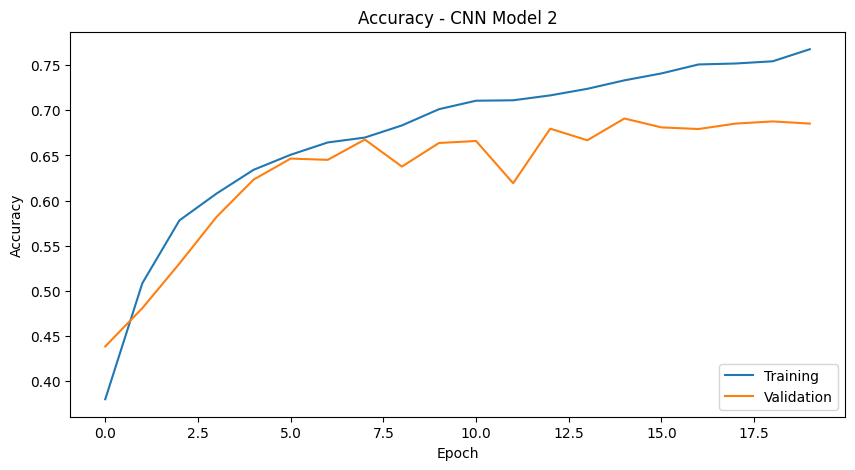

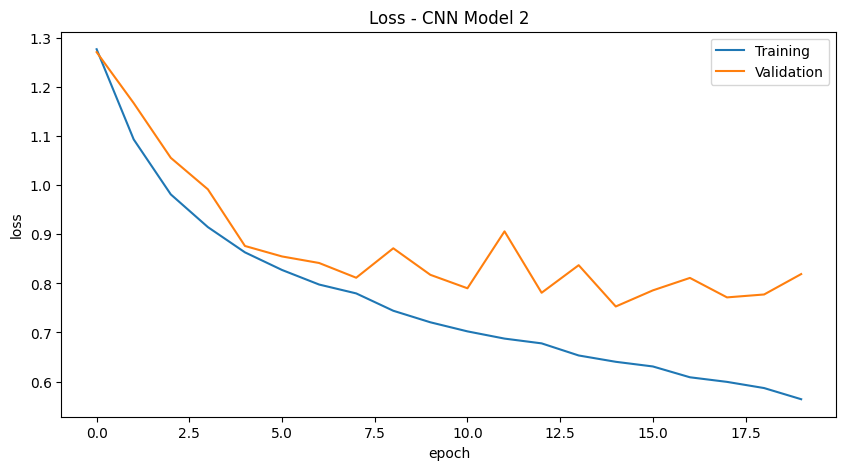

In [ ]:
# plotting the accuracies and losses

plt.figure(figsize = (10, 5))
plt.plot(cnn_model_2_history.history['accuracy'])
plt.plot(cnn_model_2_history.history['val_accuracy'])
plt.title('Accuracy - CNN Model 2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(cnn_model_2_history.history['loss'])
plt.plot(cnn_model_2_history.history['val_loss'])
plt.title('Loss - CNN Model 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### **Evaluating the Model on the Test Set**

In [ ]:
# getting the accuracy of the test set of the model
cnn_model_2_eval = cnn_model_2.evaluate(test_set)

# printing the loss and accuracy values
print('Model 2 test set loss:', cnn_model_2_eval[0])
print('Model 2 test set accuracy:', cnn_model_2_eval[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6917 - loss: 0.7925
Model 2 test set loss: 0.718950629234314
Model 2 test set accuracy: 0.71875


**Observations and Insights:**
- The model performed slightly better, with both the loss and the accuracy improving. About a 6% increase in accuracy and a 0.1 decrease in loss
- More layers led to a better performing model, so continuing to build upon this could yield even better results.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [ ]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True, brightness_range = (0., 2.), rescale = 1./255, shear_range = 0.3)

train_set = datagen_train.flow_from_directory("Facial_emotion_images/train", target_size = (img_size, img_size), color_mode = 'rgb', batch_size = batch_size, class_mode = 'categorical', classes = ['happy', 'sad', 'neutral', 'surprise'], shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True, brightness_range = (0., 2.), rescale = 1./255, shear_range = 0.3)

validation_set = datagen_validation.flow_from_directory("Facial_emotion_images/validation", target_size = (img_size, img_size), color_mode = 'rgb', batch_size = batch_size, class_mode = 'categorical', classes = ['happy', 'sad', 'neutral', 'surprise'], shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True, brightness_range = (0., 2.), rescale = 1./255, shear_range = 0.3)

test_set = datagen_test.flow_from_directory("Facial_emotion_images/test", target_size = (img_size, img_size), color_mode = 'rgb', batch_size = batch_size, class_mode = 'categorical', classes = ['happy', 'sad', 'neutral', 'surprise'], shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [ ]:
transfer_layer = vgg.get_layer('block4_pool')
vgg.trainable = False

x = Flatten()(transfer_layer.output)

# dense layers
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(rate = 0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

# classifier layer
pred = Dense(4, activation='softmax')(x)

#initialization
vgg_model = Model(vgg.input, pred)

### **Compiling and Training the VGG16 Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy

# saving a checkpoint of the weight from the best epoch
checkpoint = ModelCheckpoint("./vgg_model.keras", monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')

# early stopping for if the validation loss doesn't get better
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

# reduced learning rate for if the validation loss doesn't get better
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# compiling the model with all the parameters set
vgg_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# fitting the model
vgg_history = vgg_model.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.3914 - loss: 1.3622 - val_accuracy: 0.4686 - val_loss: 1.1825
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 72s 73ms/step - accuracy: 0.5322 - loss: 1.0702 - val_accuracy: 0.5837 - val_loss: 0.9880
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.5630 - loss: 1.0009 - val_accuracy: 0.5664 - val_loss: 0.9862
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.5953 - loss: 0.9490 - val_accuracy: 0.6243 - val_loss: 0.9061
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.6124 - loss: 0.9103 - val_accuracy: 0.6116 - val_loss: 0.9138
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.6257 - loss: 0.8886 - val_accuracy: 0.6241 - val_loss: 0.8896
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.6313 - loss: 0.8783 - val_accuracy: 0.5817 - val_loss: 0.9955
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.6453 - loss: 0.8478 - 

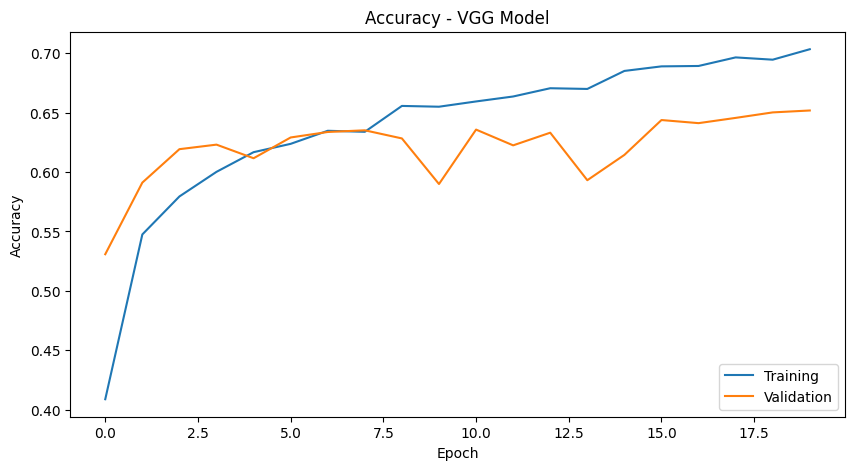

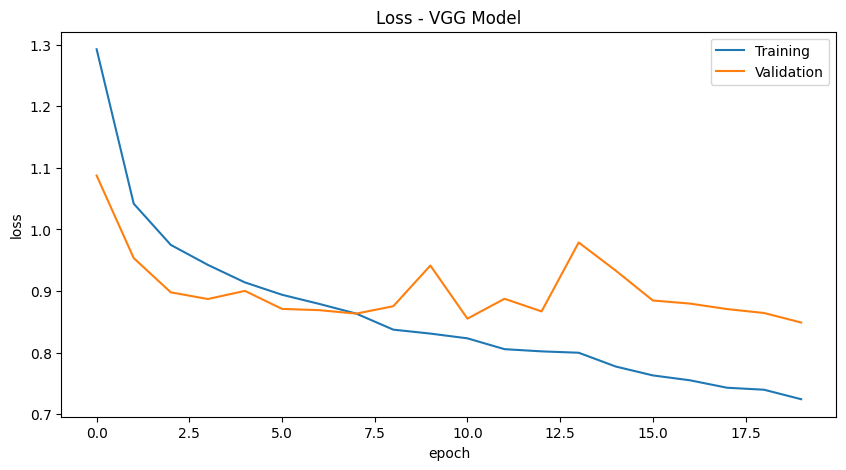

In [ ]:
# plotting the accuracies and losses

plt.figure(figsize = (10, 5))
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Accuracy - VGG Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Loss - VGG Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### **Evaluating the VGG16 model**

In [ ]:
# getting the accuracy of the test set of the model
vgg_model_eval = vgg_model.evaluate(test_set)

# printing the loss and accuracy values
print('VGG test set loss:', vgg_model_eval[0])
print('VGG test set accuracy:', vgg_model_eval[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7448 - loss: 0.7197
VGG test set loss: 0.7590141892433167
VGG test set accuracy: 0.7265625


**Observations and Insights:**
- This model was more accurate than the last CNN models
- Both the accuracy and the loss were an improvement, with a 72% accuracy and a 0.75 loss

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
resnet.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 54, 54, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 24, 24, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 24, 24, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 24, 24, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 26, 26, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 12, 12, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 12, 12, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 12, 12, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 12, 12, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 12, 12, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 42,552,832 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

### **Model Building**

In [ ]:
transfer_layer_Resnet = resnet.get_layer('conv5_block3_add')
resnet.trainable=False

x = Flatten()(transfer_layer_Resnet.output)

# dense layers
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

# classifier
pred = Dense(4, activation = 'softmax')(x)

resnet_model = Model(resnet.input, pred)

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# saving a checkpoint of the weight from the best epoch
checkpoint = ModelCheckpoint("./Resnetmodel.keras", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

# early stopping for if the validation loss doesn't get better
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True )

# reduced learning rate for if the validation loss doesn't get better
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# compiling the model with all the parameters set
resnet_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# fitting the model
history = resnet_model.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 431s 873ms/step - accuracy: 0.2524 - loss: 1.5845 - val_accuracy: 0.2289 - val_loss: 1.4305
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 398s 841ms/step - accuracy: 0.2616 - loss: 1.4130 - val_accuracy: 0.3665 - val_loss: 1.3579
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 399s 843ms/step - accuracy: 0.2625 - loss: 1.4014 - val_accuracy: 0.2289 - val_loss: 1.3741
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 404s 852ms/step - accuracy: 0.2546 - loss: 1.3990 - val_accuracy: 0.2443 - val_loss: 1.3865
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 401s 848ms/step - accuracy: 0.2552 - loss: 1.3957 - val_accuracy: 0.2443 - val_loss: 1.3626
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 452s 954ms/step - accuracy: 0.2607 - loss: 1.3930 - val_accuracy: 0.2443 - val_loss: 1.3787
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 445s 940ms/step - accuracy: 0.2642 - loss: 1.3931 - val_accuracy: 0.2443 - val_loss: 1.3746
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 461s 854ms/step - accuracy: 0.2636 -

### **Evaluating the ResNet Model**

In [ ]:
# getting the accuracy of the test set of the model
resnetmodel_eval = resnet_model.evaluate(test_set)

# printing the loss and accuracy values
print('Resnet test set loss:', resnetmodel_eval[0])
print('Resnet test set accuracy:', resnetmodel_eval[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - accuracy: 0.2635 - loss: 1.4009
Resnet test set loss: 1.409513235092163
Resnet test set accuracy: 0.25


**Observations and Insights:**
- This model didn't work particularly well with image processing
- Both the loss and the accuracy stayed at around the same area, no improvement or decline
- No graphs for this model because they wouldn't show anything of value

**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**

## **EfficientNet Model**

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
efficientnet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

efficientnet.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 48, 48, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 48, 48, 3)      │              0 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 24, 24, 32)     │            864 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 24, 24, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 24, 24, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 24, 24, 16)     │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 24, 24, 16)     │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 24, 24, 16)     │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 24, 24, 16)     │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 24, 24, 16)     │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 24, 24, 16)     │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 24, 24, 16)     │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 24, 24, 16)     │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├──────────────────────

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

### **Model Building**

In [ ]:
transfer_layer_EfficientNet = efficientnet.get_layer('block6e_expand_activation')
efficientnet.trainable = False

x = Flatten()(transfer_layer_EfficientNet.output)

# dense layers
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

# classifier layer
pred = Dense(4, activation = 'softmax')(x)

efficientnetmodel = Model(efficientnet.input, pred) # Initializing the model

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy

# saving a checkpoint of the weight from the best epoch
checkpoint = ModelCheckpoint("./Efficientnetmodel.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# early stopping for if the validation loss doesn't get better
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True )

# reduced learning rate for if the validation loss doesn't get better
reduce_learningrate =  ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

# compiling the model with all the parameters set
efficientnetmodel.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# fitting the model
history = efficientnetmodel.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 142s 267ms/step - accuracy: 0.2522 - loss: 1.5298 - val_accuracy: 0.3667 - val_loss: 1.3886
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 145s 306ms/step - accuracy: 0.2666 - loss: 1.4127 - val_accuracy: 0.2289 - val_loss: 1.3889
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 195s 292ms/step - accuracy: 0.2607 - loss: 1.4001 - val_accuracy: 0.3667 - val_loss: 1.3486
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 126s 266ms/step - accuracy: 0.2652 - loss: 1.3958 - val_accuracy: 0.3667 - val_loss: 1.3587
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 140s 262ms/step - accuracy: 0.2597 - loss: 1.3954 - val_accuracy: 0.3667 - val_loss: 1.3712
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 121s 256ms/step - accuracy: 0.2623 - loss: 1.3936 - val_accuracy: 0.2443 - val_loss: 1.3599
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 153s 280ms/step - accuracy: 0.2658 - loss: 1.3898 - val_accuracy: 0.3667 - val_loss: 1.3683
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 145s 286ms/step - accuracy: 0.2570 -

### **Evaluating the EfficientnetNet Model**

In [ ]:
# getting the accuracy of the test set of the model
efficientnetmodel_eval = efficientnetmodel.evaluate(test_set)

# printing the loss and accuracy values
print('EfficientNet test set loss:', efficientnetmodel_eval[0])
print('EfficientNet test set accuracy:', efficientnetmodel_eval[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.2469 - loss: 1.3918
EfficientNet test set loss: 1.3886340856552124
EfficientNet test set accuracy: 0.25


**Observations and Insights:**
- This model didn't work particularly well with image processing
- Both the loss and the accuracy stayed at around the same area, no improvement or decline

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [ ]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True, brightness_range = (0., 2.), rescale = 1./255, shear_range = 0.3)

train_set = datagen_train.flow_from_directory("Facial_emotion_images/train", target_size = (img_size, img_size), color_mode = 'grayscale', batch_size = batch_size, class_mode = 'categorical', classes = ['happy', 'sad', 'neutral', 'surprise'], shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True, brightness_range = (0., 2.), rescale = 1./255, shear_range = 0.3)

validation_set = datagen_validation.flow_from_directory("Facial_emotion_images/validation", target_size = (img_size, img_size), color_mode = 'grayscale', batch_size = batch_size, class_mode = 'categorical', classes = ['happy', 'sad', 'neutral', 'surprise'], shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True, brightness_range = (0., 2.), rescale = 1./255, shear_range = 0.3)

test_set = datagen_test.flow_from_directory("Facial_emotion_images/test", target_size = (img_size, img_size), color_mode = 'grayscale', batch_size = batch_size, class_mode = 'categorical', classes = ['happy', 'sad', 'neutral', 'surprise'], shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

In [ ]:
cnn_model_3 = Sequential()

# add 1st CNN block
cnn_model_3.add(Conv2D(64, kernel_size=(2), padding='same', activation='relu', input_shape=(48,48,1)))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(LeakyReLU(alpha=0.1))
cnn_model_3.add(MaxPooling2D(pool_size=(2)))
cnn_model_3.add(Dropout(rate=0.2))

# add 2nd CNN block
cnn_model_3.add(Conv2D(128, kernel_size=(2), padding='same', activation='relu'))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(LeakyReLU(alpha=0.1))
cnn_model_3.add(MaxPooling2D(pool_size=(2)))
cnn_model_3.add(Dropout(rate=0.2))

# add 3rd CNN block
cnn_model_3.add(Conv2D(512, kernel_size=(2), padding='same', activation='relu'))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(LeakyReLU(alpha=0.1))
cnn_model_3.add(MaxPooling2D(pool_size=(2)))
cnn_model_3.add(Dropout(rate=0.2))

# add 4th CNN block
cnn_model_3.add(Conv2D(512, kernel_size=(2), padding='same', activation='relu'))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(LeakyReLU(alpha=0.1))
cnn_model_3.add(MaxPooling2D(pool_size=(2)))
cnn_model_3.add(Dropout(rate=0.2))

# add 5th CNN block
cnn_model_3.add(Conv2D(128, kernel_size=(2), padding='same', activation='relu'))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(LeakyReLU(alpha=0.1))
cnn_model_3.add(MaxPooling2D(pool_size=(2)))
cnn_model_3.add(Dropout(rate=0.2))

cnn_model_3.add(Flatten())

# first connected layer
cnn_model_3.add(Dense(256, activation='relu'))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(Dropout(rate=0.2))

# second connected layer
cnn_model_3.add(Dense(512, activation='relu'))
cnn_model_3.add(BatchNormalization())
cnn_model_3.add(Dropout(rate=0.2))

cnn_model_3.add(Dense(4, activation = 'softmax'))

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("/model3.weights.h5", monitor = 'val_accuracy', save_weights_only = True, verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001)

callbacks = [checkpoint, reduce_lr]

cnn_model_3.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.003), metrics=["accuracy"])
history = cnn_model_3.fit(train_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 416s 862ms/step - accuracy: 0.2674 - loss: 1.7959 - val_accuracy: 0.3404 - val_loss: 1.6260
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 438s 856ms/step - accuracy: 0.2914 - loss: 1.4493 - val_accuracy: 0.3456 - val_loss: 1.4761
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 408s 862ms/step - accuracy: 0.3569 - loss: 1.3469 - val_accuracy: 0.3697 - val_loss: 1.2870
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 423s 893ms/step - accuracy: 0.4123 - loss: 1.2430 - val_accuracy: 0.3665 - val_loss: 1.3064
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 409s 865ms/step - accuracy: 0.4766 - loss: 1.1474 - val_accuracy: 0.5089 - val_loss: 1.0934
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 440s 862ms/step - accuracy: 0.5213 - loss: 1.0724 - val_accuracy: 0.4752 - val_loss: 1.1714
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 410s 867ms/step - accuracy: 0.5540 - loss: 1.0235 - val_accuracy: 0.5118 - val_loss: 1.2527
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 440s 863ms/step - accuracy: 0.5746 -

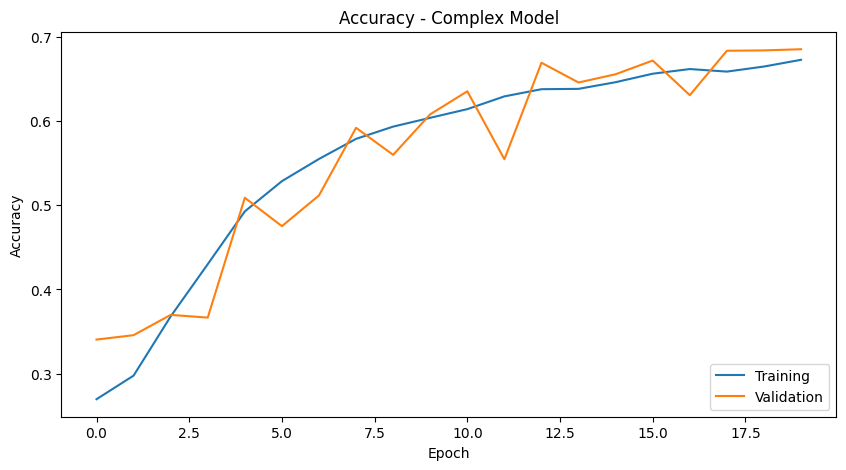

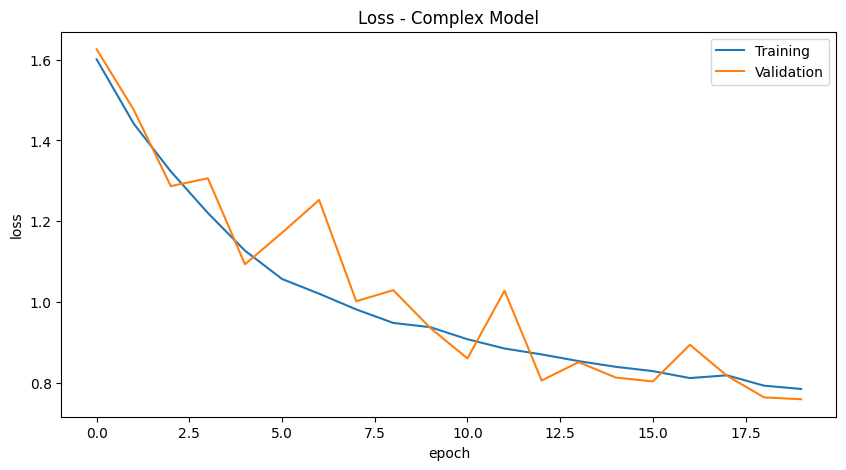

In [ ]:
# plotting the accuracies and losses

plt.figure(figsize = (10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy - Complex Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss - Complex Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### **Evaluating the Model on Test Set**

In [ ]:
# getting the accuracy of the test set of the model
cnn_model_3_eval = cnn_model_3.evaluate(test_set)

# printing the loss and accuracy values
print('CNN model 3 test set loss:', cnn_model_3_eval[0])
print('CNN model 3 test set accuracy:', cnn_model_3_eval[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step - accuracy: 0.6562 - loss: 0.7347
CNN model 3 test set loss: 0.7347002029418945
CNN model 3 test set accuracy: 0.65625


**Observations and Insights:**
- The complex model was much more accurate than some of the other models that were run earlier
- With only 10 epochs, the accuracy was able to get to 60% accuracy, and with more epochs it could've been higher

### **Plotting the Confusion Matrix for the chosen final model**

Found 128 images belonging to 4 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        32
           1       0.60      0.56      0.58        32
           2       0.46      0.75      0.57        32
           3       1.00      0.66      0.79        32

    accuracy                           0.65       128
   macro avg       0.72      0.65      0.66       128
weighted avg       0.72      0.65      0.66       128



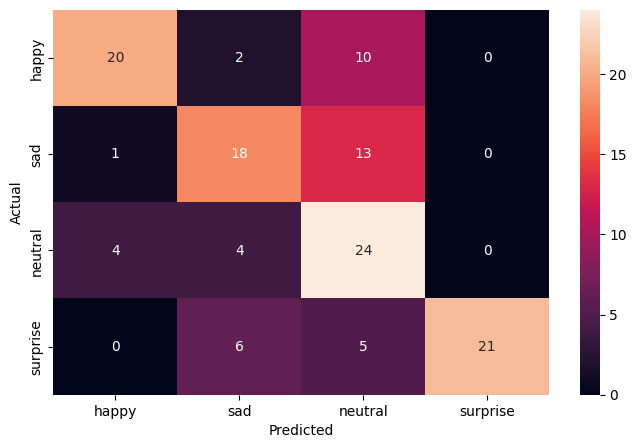

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
test_set = datagen_test.flow_from_directory("Facial_emotion_images/test", target_size = (img_size,img_size), color_mode = 'rgb', batch_size = 128, class_mode = 'categorical', classes = ['happy', 'sad', 'neutral', 'surprise'], shuffle = True)
test_images, test_labels = next(test_set)

pred = vgg_model.predict(test_images)
pred = np.argmax(pred, axis=1)

y_true = np.argmax(test_labels, axis=1)

# classification report
print(classification_report(y_true, pred))

# confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=['happy', 'sad', 'neutral', 'surprise'], yticklabels=['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:**
- I chose to use the VGG16 model due to the success based on accuracy and loss, although the complex model (3rd CNN model) would have been the second choice based on the same metrics
- Looking at the confusion matrix, we can see that neutral performed the best, happy and surprised performed about the same, and sad performed the worst
- Upon further inspection of the sad category, the sad pictures and the neutral images are the ones that got mixed up the most.
- The one category that saw the best as neutral as stated above, and that was assumingly because the neutral faces are the easiest to distinguish (aka no features to look for)

## **Conclusion:**
- Only a few models would be worth pursuing, as some of them scored low the entire time while others consistently got better
- Images are a hard thing for models to process, so although some may be struggling, it may just not be meant for images.

### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?
 - The models VGG16 and the Complex Model performed the best, and the ResNet and the EfficientNet models performed the worst
  - There were a few of the models that performed in the middle of the pack, although if we built upon some of them, then maybe they could've performed better  
- I do believe that although our models performed well, they did not perform well enough to be used for Emotion AI. A ~70% accuracy is not good enough, and with bigger datasets, that would become an issue with that low of an accuracy
- Our models would also need to be able to detect any images that would cause issues (photoshopped images, all black images, bad quality images) so the accuracy won't tank. Another thing to keep in mind is that images may be in different colors (rgb, grayscale), so the model would need to perform the same for both kinds of images

### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?
 - I think using a same number of epochs hindered some models performances, using more epochs would be able to show which ones are truly better
 - As I said above, building upon some of the models could bring better results



 *   CNN Model 1:
  *   Accuracy: 63%
  *   Loss: 0.83
 *   CNN Model 2:
  *   Accuracy: 72%
  *   Loss: 0.72
 *   VGG16:
  *   Accuracy: 72%
  *   Loss: 0.75
 *   ResNet:
  *   Accuracy: 25%
  *   Loss: 1.4
 *   EfficientNet:
  *   Accuracy: 25%
  *   Loss: 1.4
 *   Complex Model:
  *   Accuracy: 65%
  *   Loss: 0.73

- As you can see, in comparison only ResNet and EfficientNet performed in a different ballpark than the rest.


### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?
 - It has to be the VGG16 model, and the reason why that is is because that performed the best despite their flaws. Although with the CNN models, if we build upon that, it could become as good of a performer as the VGG16 model was.
